<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparissons-of-GP-methods-in-Python-with-Matlab-GP" data-toc-modified-id="Comparissons-of-GP-methods-in-Python-with-Matlab-GP-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparissons of GP methods in Python with Matlab GP</a></span><ul class="toc-item"><li><span><a href="#Load-training-data-and-Matlab-GP-data" data-toc-modified-id="Load-training-data-and-Matlab-GP-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load training data and Matlab GP data</a></span></li><li><span><a href="#Scikit-Learn-GP-vs-Matlab-GP" data-toc-modified-id="Scikit-Learn-GP-vs-Matlab-GP-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Scikit Learn GP vs Matlab GP</a></span></li><li><span><a href="#GPflow-GP-vs-Matlab-GP" data-toc-modified-id="GPflow-GP-vs-Matlab-GP-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>GPflow GP vs Matlab GP</a></span></li><li><span><a href="#GPyTorch-GP-vs-Matlab-GP" data-toc-modified-id="GPyTorch-GP-vs-Matlab-GP-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>GPyTorch GP vs Matlab GP</a></span></li></ul></li></ul></div>

# Comparissons of GP methods in Python with Matlab GP

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
import math
import csv

## Load training data and Matlab GP data

In [2]:
# Load X data (5D) from file
X = np.loadtxt('SF5d_relu_1000.dat')

# Load Y data from file
Y = np.loadtxt('SF5d_relu_1000_output.dat')
Y = Y[:, [0,1]] # Use the first 2 components

# Read Matlab prediction data from file
Y_Mat = np.loadtxt('SF5d_relu_1000_pred.dat')

## Scikit Learn GP vs Matlab GP

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

In [4]:
# Define a Gaussian process
def GP(X_train, Y_train):
    # fit Gaussian Process with dataset X_train, Y_train
    kernel = RBF(0.5, (0.01, 2)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, Y_train)
    return gp

In [5]:
# Train a GP with the data above
gp = GP(X, Y)

In [6]:
Y_SKLearn = gp.predict(X)

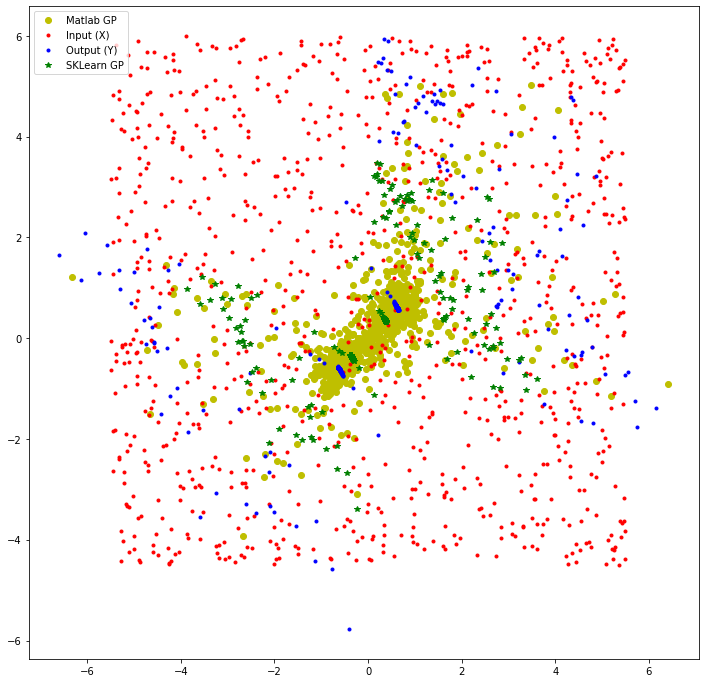

In [7]:
fig = plt.figure(figsize=(12,12))

plt.plot(Y_Mat[:,0], Y_Mat[:,1], 'yo', label='Matlab GP');
plt.plot(X[:,0], X[:,1], 'r.', label='Input (X)');
plt.plot(Y[:,0], Y[:,1], 'b.', label='Output (Y)');
plt.plot(Y_SKLearn[:,0], Y_SKLearn[:,1], 'g*', label='SKLearn GP');

plt.legend(loc="upper left");

In [8]:
MSE_Mat = ((Y_Mat - Y)**2).mean()
MSE_SKLearn = ((Y_SKLearn - Y)**2).mean()

print('Matlab Mean Squared Error (MSE):', MSE_Mat)
print('SKLearn Mean Squared Error (MSE):', MSE_SKLearn)

Matlab Mean Squared Error (MSE): 0.3200490994327563
SKLearn Mean Squared Error (MSE): 0.2913766174515656


## GPflow GP vs Matlab GP

In [9]:
# Install gpflow with: pip install gpflow
# See: https://github.com/GPflow/GPflow
import gpflow

In [10]:
# Choose kernel
kernel = gpflow.kernels.Matern52()

# Define model
model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)

# Choose optimizer
optimizer = gpflow.optimizers.Scipy()

In [11]:
# Run optimizer
optimizer_logs = optimizer.minimize(model.training_loss, model.trainable_variables,
                                    options=dict(maxiter=100))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [12]:
# Predict with the trained model
Y_GPflow, var = model.predict_f(X)

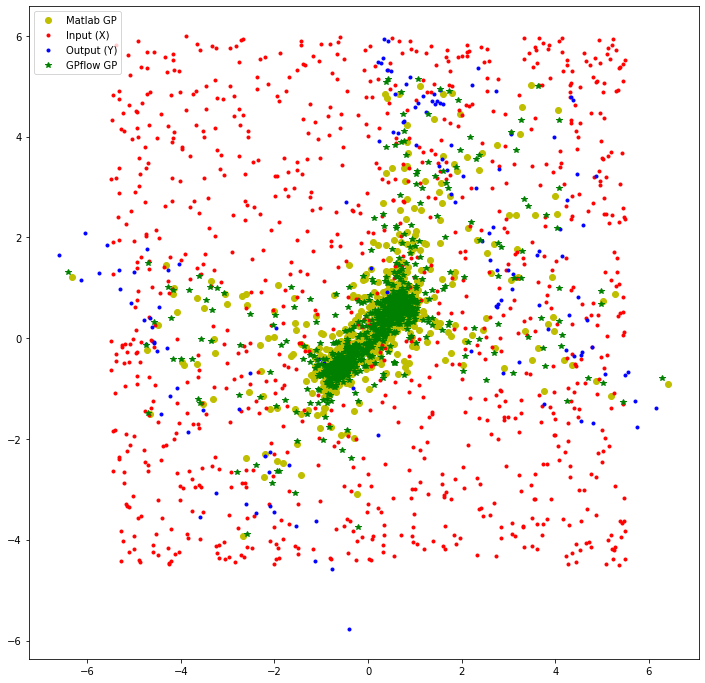

In [13]:
fig = plt.figure(figsize=(12,12))

plt.plot(Y_Mat[:,0], Y_Mat[:,1], 'yo', label='Matlab GP');
plt.plot(X[:,0], X[:,1], 'r.', label='Input (X)');
plt.plot(Y[:,0], Y[:,1], 'b.', label='Output (Y)');
plt.plot(Y_GPflow[:,0], Y_GPflow[:,1], 'g*', label='GPflow GP');

plt.legend(loc="upper left");

In [14]:
MSE_Mat = ((Y_Mat - Y)**2).mean()
MSE_GPflow = ((np.array(Y_GPflow) - Y)**2).mean()

print('Matlab Mean Squared Error (MSE):', MSE_Mat)
print('GPflow Mean Squared Error (MSE):', MSE_GPflow)

Matlab Mean Squared Error (MSE): 0.3200490994327563
GPflow Mean Squared Error (MSE): 0.22359626327942778


## GPyTorch GP vs Matlab GP

In [15]:
# Install with:
# pip install torch
# pip install gpytorch
# See: https://gpytorch.ai/
import torch
import gpytorch

In [16]:
# Transfor X and Y into torch tensors
train_x = torch.tensor(X, dtype=torch.float32)
train_y = torch.stack([torch.tensor(Y[:,0], dtype=torch.float32),
                       torch.tensor(Y[:,1], dtype=torch.float32),
                      ], -1)

output_dim = 2

In [17]:
# Define GPyTorch model
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_dim]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_dim])),
            batch_shape=torch.Size([output_dim])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim)
model = BatchIndependentMultitaskGPModel(train_x, train_y, likelihood)

In [18]:
# Train the model

training_iterations = 100
# training_iterations = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

In [19]:
# Predict with the trained model
test_x = train_x

# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x))
    Y_GPyTorch = predictions.mean
    lower, upper = predictions.confidence_region()

/Users/gameiro/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


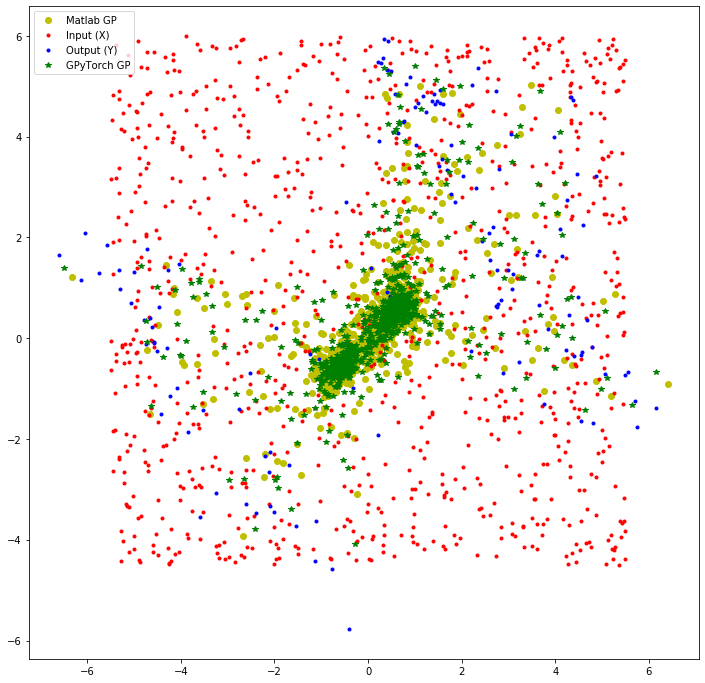

In [20]:
fig = plt.figure(figsize=(12,12))

plt.plot(Y_Mat[:,0], Y_Mat[:,1], 'yo', label='Matlab GP');
plt.plot(X[:,0], X[:,1], 'r.', label='Input (X)');
plt.plot(Y[:,0], Y[:,1], 'b.', label='Output (Y)');
plt.plot(Y_GPyTorch[:,0], Y_GPyTorch[:,1], 'g*', label='GPyTorch GP');

plt.legend(loc="upper left");

In [21]:
MSE_Mat = ((Y_Mat - Y)**2).mean()
MSE_GPyTorch = ((np.array(Y_GPyTorch) - Y)**2).mean()

print('Matlab Mean Squared Error (MSE):', MSE_Mat)
print('GPyTorch Mean Squared Error (MSE):', MSE_GPyTorch)

Matlab Mean Squared Error (MSE): 0.3200490994327563
GPyTorch Mean Squared Error (MSE): 0.18248594388377642
